In [53]:
%pylab inline

import numpy as np
import os
import pysumma as ps
import itertools
import xarray as xr
import cycler
from pprint import pprint as pp
import seaborn as sns
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/srv/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cycler']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Setup PySUMMA to run by setting decisions and parameters 

In [54]:
sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = (24, 10)

user = os.environ['USER']
file_manager = ('/home/jovyan/whw2019_snow_modeling/summa_setup/file_manager.txt')
summa_exe = 'summa.exe'
        
decisions_options = {
#     #'thCondSnow': ['tyen1965', 'melr1977'],#, 'jrdn1991', 'smnv2000'],
#     'compaction': ['consettl', 'anderson'],
#     'snowDenNew': ['hedAndPom', 'pahaut_76'],
#     'snowLayers': ['CLM_2010']
}

param_options = {
        'albedoMax': [0.6, 0.7, 0.8, 0.9],
        'albedoDecayRate': [1.0e+5, 1.0e+6, 5.0e+6]
}

# Link to where you can find output variables:
#  https://github.com/NCAR/summa/blob/master/build/source/dshare/var_lookup.f90
output_vars_to_add = ['mLayerTemp']
    
#config = ps.ensemble.total_product(decisions_options, param_options)
# config = ps.ensemble.decision_product(decisions_options)
config = ps.ensemble.parameter_product(param_options)
stack_dims = list(decisions_options.keys()) + list(param_options.keys())
len(config)

12

## Create an ensemble pandas dictionary that contains the PySUMMA setup files

In [2]:
ens = ps.Ensemble(summa_exe, file_manager, config, num_workers=2)
#for name, sim in ens.simulations.items():
#    for out_var in output_vars_to_add:
#        sim.output_control.set_option(name=var, period=1)

## RUN THE MODEL!!!

In [3]:
ens.start('local')
ens.monitor()

Output information if the model crashes:

In [4]:
for i, (n, s) in enumerate(ens.simulations.items()):
    if s._status != 'Success':
        print(i, f'{n:100}', s._status)

Combine the outputs into a dataframe, and check the output diagnostics:

In [5]:
ds = ens.merge_output()
ds

# Here's a slick function to derive the water year for each output time step (thanks Bart!).

In [7]:
def calc_water_year(ds):
    return ds.time.dt.year + (ds.time.dt.month >= 10)

In [8]:
wyhr = calc_water_year(ds['time'])
ds['wy'] = wyhr

In [9]:
# ens.simulations.keys()

dict_keys(['++albedoMax=0.6++albedoDecayRate=100000.0++', '++albedoMax=0.6++albedoDecayRate=1000000.0++', '++albedoMax=0.6++albedoDecayRate=5000000.0++', '++albedoMax=0.7++albedoDecayRate=100000.0++', '++albedoMax=0.7++albedoDecayRate=1000000.0++', '++albedoMax=0.7++albedoDecayRate=5000000.0++', '++albedoMax=0.8++albedoDecayRate=100000.0++', '++albedoMax=0.8++albedoDecayRate=1000000.0++', '++albedoMax=0.8++albedoDecayRate=5000000.0++', '++albedoMax=0.9++albedoDecayRate=100000.0++', '++albedoMax=0.9++albedoDecayRate=1000000.0++', '++albedoMax=0.9++albedoDecayRate=5000000.0++'])

## Create a stacked dictionary of all twelve model runs.

In [45]:
stack_dims = list(decisions_options.keys()) + list(param_options.keys())
ds_stack = ds.stack(model=stack_dims).isel(hru=0, drop=True)
# ds_stack['model'].values=np.arange(len(stack_dims))

## Read in the snow depth measurements from the Mammoth Mountain CUES Site.

In [45]:
obs = pd.read_csv('../data/MHP2011to2017_SnowDepth_SWE_Precip.csv', index_col=0, parse_dates=True)
# obs.keys()

Index(['SnowDepth_cm', 'SnowDepth_src', 'precip_cm_hr', 'precip_src', 'SWE_cm',
       'SWE_src'],
      dtype='object')

## Plot the time series of modeled snow depths for each albedo parameterization

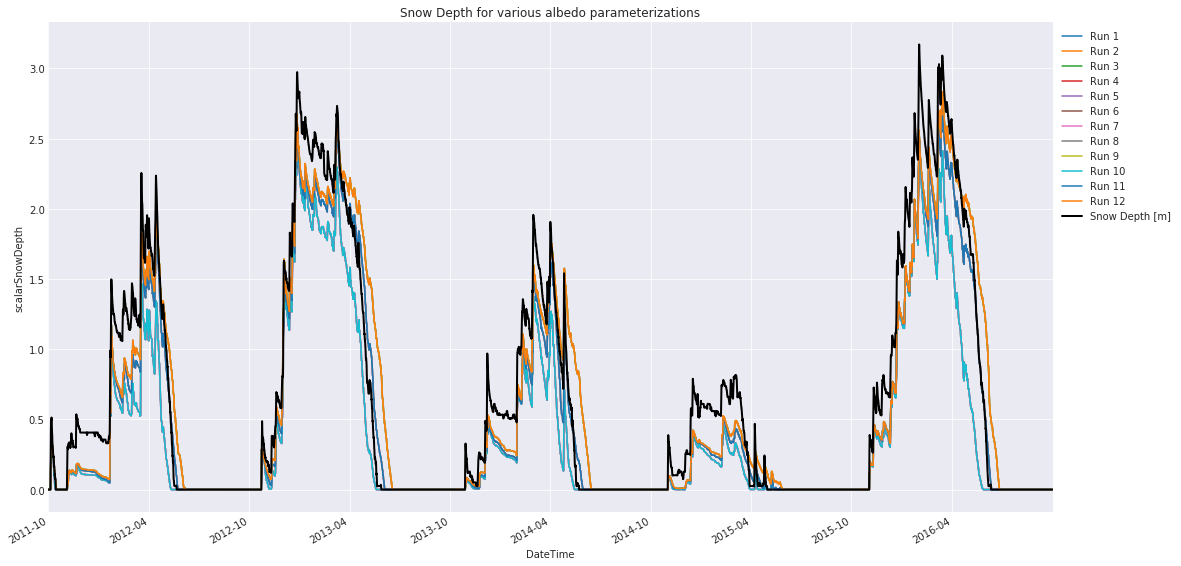

In [49]:
# variable to define date range of plot.
window = slice('10/01/2011', '9/30/2016')

# plot the modeled snow depth for each albedo parameterization:
plt.figure(figsize=[18, 10]);

for ind in range(0,12):
   ds_stack.scalarSnowDepth.isel(model=ind).sel(time=window).plot(label='Run {}'.format(ind+1))

# convert the snow depth measurements from cm to m and then plot
snow_depth_m = 1e-2*obs['SnowDepth_cm']
mask = (snow_depth_m.index > '10/01/2011') & (snow_depth_m.index <= '9/30/2016')
snow_depth_m.loc[mask].plot(label='Snow Depth [m]', color='black', linewidth=2)

plt.legend(loc='upper left',bbox_to_anchor=(1, 1));
plt.title('Snow Depth for various albedo parameterizations');

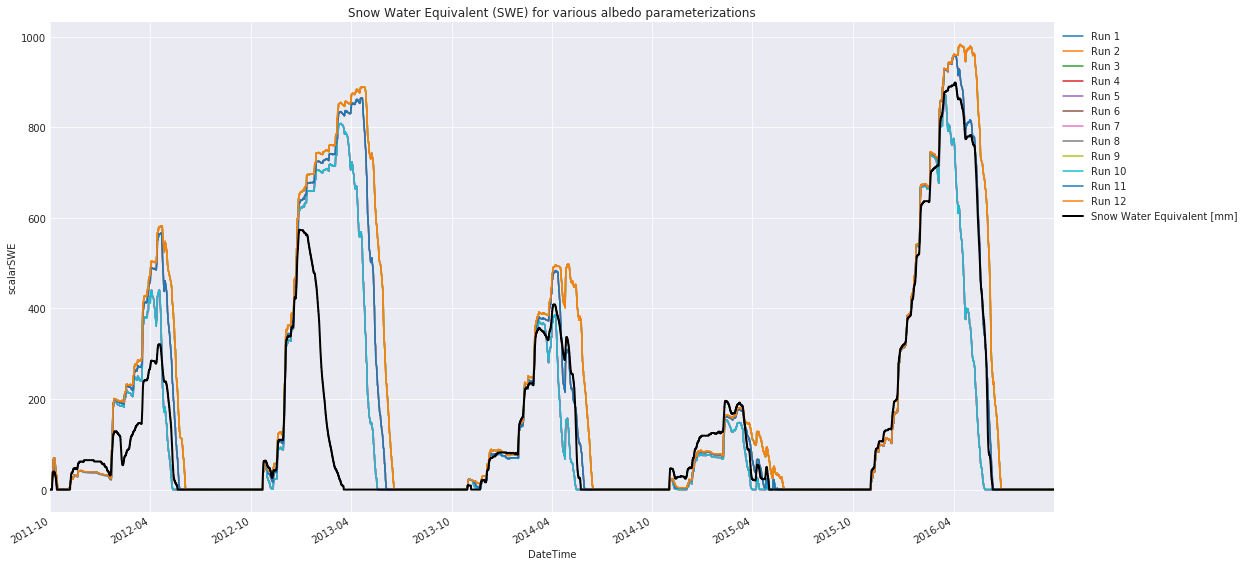

In [51]:
# plot the modeled SWE for each albedo parameterization:
plt.figure(figsize=[18, 10]);

for ind in range(0,12):
   ds_stack.scalarSWE.isel(model=ind).sel(time=window).plot(label='Run {}'.format(ind+1))

# convert the swe measurements from cm to mm
swe_mm = 10*obs['SWE_cm']
mask = (swe_mm.index > '10/01/2011') & (swe_mm.index <= '9/30/2016')
swe_mm.loc[mask].plot(label='Snow Water Equivalent [mm]', color='black', linewidth=2)

plt.legend(loc='upper left',bbox_to_anchor=(1, 1));
plt.title('Snow Water Equivalent (SWE) for various albedo parameterizations');

In [ ]:
# (ds['scalarSnowDepth']
#     .sel(hru=1, albedo=0.6, snowDenNew='hedAndPom', snowLayers='CLM_2010', time=window)
#     .plot(label='++albedoMax=0.6++albedoDecayRate=100000.0++'));
# (ds['scalarSnowDepth']
#     .sel(hru=1, compaction='consettl', snowDenNew='pahaut_76', snowLayers='CLM_2010', time=window)
#     .plot(label='++albedoMax=0.6++albedoDecayRate=1000000.0++'));
# (ds['scalarSnowDepth']
#     .sel(hru=1, compaction='anderson', snowDenNew='hedAndPom', snowLayers='CLM_2010', time=window)
#     .plot(label='++anderson++hedAndPom++CLM_2010++'));
# (ds['scalarSnowDepth']
#     .sel(hru=1, compaction='anderson', snowDenNew='pahaut_76', snowLayers='CLM_2010', time=window)
#     .plot(label='++anderson++pahaut_76++CLM_2010++'));


# plot the cumulative modeled runoff (surface water input) from the snowpack base:
# first convert units from m/s to mm/hour
# runoff_depth_perhour =ds['scalarTotalRunoff']*3600*1000

# ax = plt.gca().twinx()
# (runoff_depth_perhour
#      .sel(hru=1, thCondSnow='melr1977', time=window)
#      .groupby(ds['wy'])
#      .apply(np.cumsum, axis=0)
#      .plot(label='Mellor', color='black'));
# (runoff_depth_perhour
#     .sel(hru=1, thCondSnow='tyen1965', time=window)
#     .groupby(ds['wy'])
#     .apply(np.cumsum, axis=0)
#     .plot(label='Tyen', color='tomato'));